<center><br><font size=10>FINAL PROJECT</font><br>
<font size=6>Team 12</font>
<br><br>
<b>Michal Gogol & Shir Berson</b>
<br><br>


## Import libraries

In [1424]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
import time
from scipy.stats import boxcox
from typing import List, Dict
import warnings
warnings.filterwarnings('ignore')

In [1425]:
start_time =time.time()

## PART1 - EXPLORATION

In [1426]:
train_data = pd.read_csv('train.csv')
X = train_data.iloc[:, :-1]  # Select all columns except the last one as features
y = train_data.iloc[:, -1]  # Select the last column as labels
# In order to have the ability to check ourseleves, we split the train data into train and test right in the begining :
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Discovering the number of samples and features
print("Shape of the train data:", X_train.shape)

# Finding if there are binary features :
# Calculate unique value counts for each feature
unique_counts = X_train.nunique()
# Identify features with a small number of unique values (e.g., binary features)
binary_features = unique_counts[unique_counts == 2].index

# Convert binary features to categorical data type
X_train[binary_features] = X_train[binary_features].astype('category')

# Separate numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns #includes the label
print("Numeric Features", numeric_features)
print("Categorial Features", categorical_features)

Shape of the train data: (48000, 23)
Numeric Features Index(['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'paths',
       'urls', 'registry', 'MZ', 'printables', 'avlength',
       'file_type_prob_trid', 'A', 'B'],
      dtype='object')
Categorial Features Index(['sha256', 'has_debug', 'has_relocations', 'has_resources',
       'has_signature', 'has_tls', 'file_type_trid', 'C'],
      dtype='object')


In [1427]:
# Get summary statistics of numeric features only
numeric_feature_stats = X_train[numeric_features].describe()
print(numeric_feature_stats)

               size         vsize       imports       exports        symbols  \
count  4.800000e+04  4.646800e+04  46591.000000  46321.000000   45901.000000   
mean   1.487790e+06  1.983077e+06    106.071602     30.137778      41.238862   
std    4.527823e+06  2.222179e+07    209.175454    507.278529    1319.018297   
min    2.980000e+02  5.440000e+02      0.000000      0.000000       0.000000   
25%    1.089920e+05  1.228800e+05      1.000000      0.000000       0.000000   
50%    4.843520e+05  4.218880e+05     28.000000      0.000000       0.000000   
75%    1.231360e+06  1.601536e+06    152.000000      0.000000       0.000000   
max    3.253537e+08  4.278288e+09  15047.000000  48840.000000  181660.000000   

         numstrings         paths          urls      registry            MZ  \
count  4.582500e+04  45058.000000  46126.000000  45980.000000  45540.000000   
mean   7.355795e+03      1.636979     12.454668      0.435907     15.972310   
std    2.413696e+04     35.926116     75.6

**Conclusion:** <br>The features 'size', 'vsize', and 'printables' exhibit large values and significant differences between their minimum and maximum values. These characteristics suggest the need for mathematical transformations to normalize the data and potentially improve the performance of machine learning algorithms later on. 

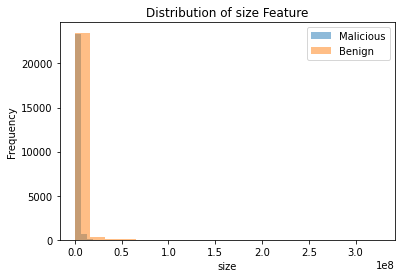

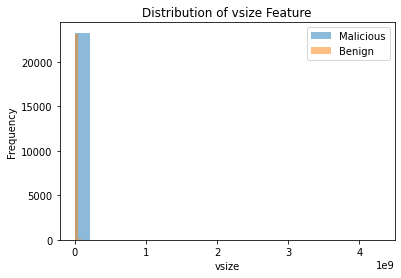

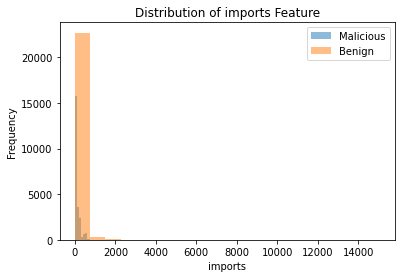

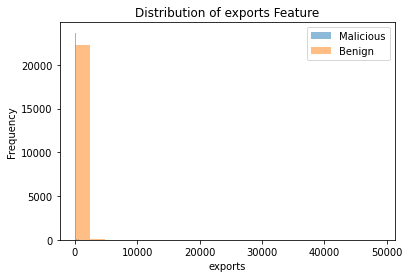

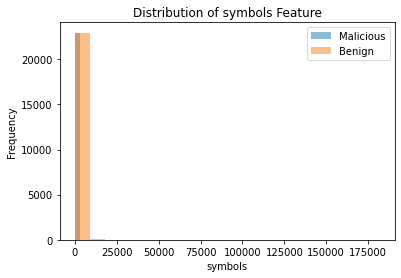

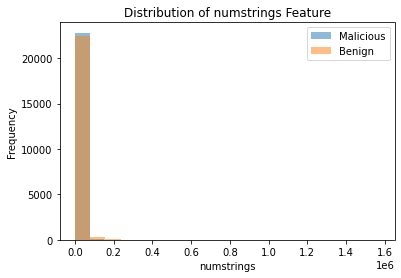

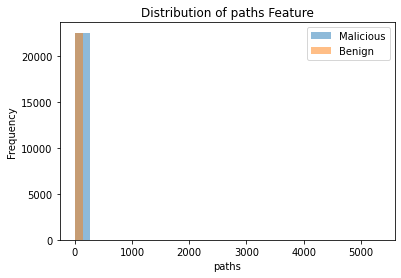

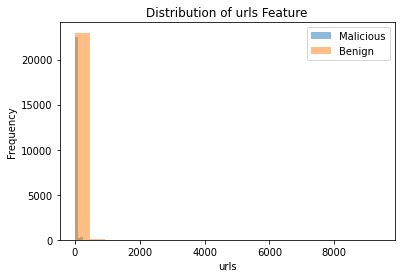

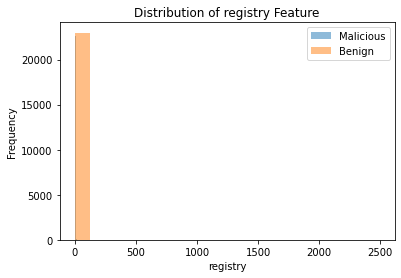

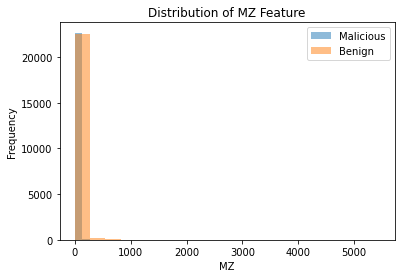

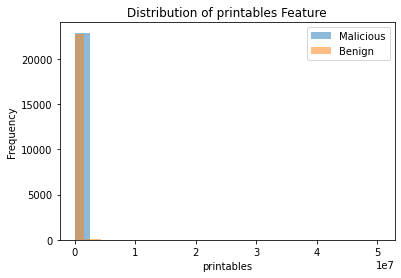

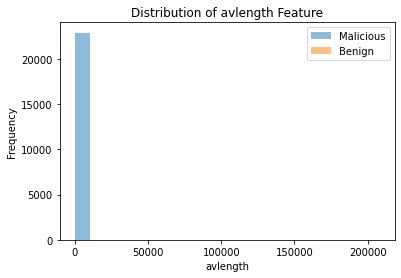

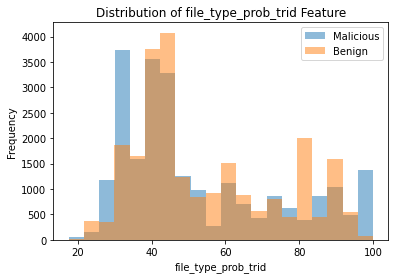

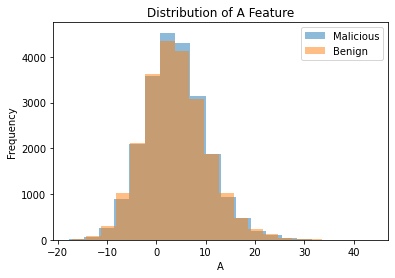

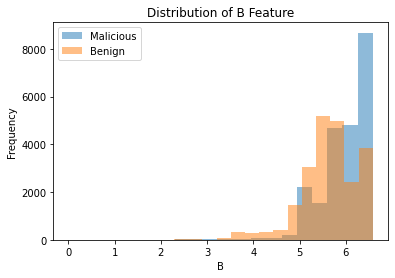

In [1428]:
#A histogram is a graphical representation of the distribution of data points in a given feature. 
# It helps in visualizing the underlying frequency or count of data points within specific intervals, known as bins.
# Each feature is separated based on the target variable (malicious and benign files), and the histograms are plotted for each class.

# Iterate over each numeric feature
for feature in numeric_features:
    # Separate each feature based on the target variable
    feature_malicious = X_train.loc[y_train == 1, feature]
    feature_benign = X_train.loc[y_train == 0, feature]
    # Set the x-axis limits
    #plt.xlim(0, 10000)
    # Plot histograms for each class
    plt.hist(feature_malicious, bins=20, alpha=0.5, label='Malicious')
    plt.hist(feature_benign, bins=20, alpha=0.5, label='Benign')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature} Feature')
    plt.legend()
    plt.show()

We used histogram because a histogram is a graphical representation of the distribution of data points in a given feature. It helps in visualizing the underlying frequency or count of data points within specific intervals, known as bins. <br>
The histograms are displayed with different colors and labeled accordingly. By comparing the histograms,
we can visually assess if there are noticeable differences in the distribution of each feature between malicious and benign files.<br>
**Conclusion:** <br>
* Feature 'A' has a bell-shaped or symmetric distribution, which suggests that the data is evenly distributed around the central tendency (mean). It indicates a normal distribution of values.<br>
* Feature 'B' looks like Negatively Skewed (Left-skewed). The tail of the histogram extends towards the left, indicating a concentration of larger values. It suggests that the majority of data points are larger, and there may be some outliers with smaller values.<br>
* Feaure 'file_type_prob_trid' is suspected as Multimodal Distribution.<br>
* We can also suspect that those features: size,vsize, imports, exports, paths, numstrings, symbpls, urls, MZ, registry and printables, has similar distribution though in a different scale. <br>
* We can see from features 'size','numstrings', 'imports','exports, 'MZ', 'urls' and 'ptintables' histograms that there are samples that are significantly different from the majority of the data points. Therefore they are mabye Outliers.<br>
* It looks like in feature 'avlength' all the the samples are labeled as malicious! The fact that the feature's histogram exclusively contains values associated with malicious files suggests that there may be a strong association between that feature and the label. This indicates that the feature has discriminatory power and can potentially be informative in distinguishing between malicious and benign files.
* It looks like in features 'exports' and 'registry' most of the samples which their value is higher than 0, are labled as benign.

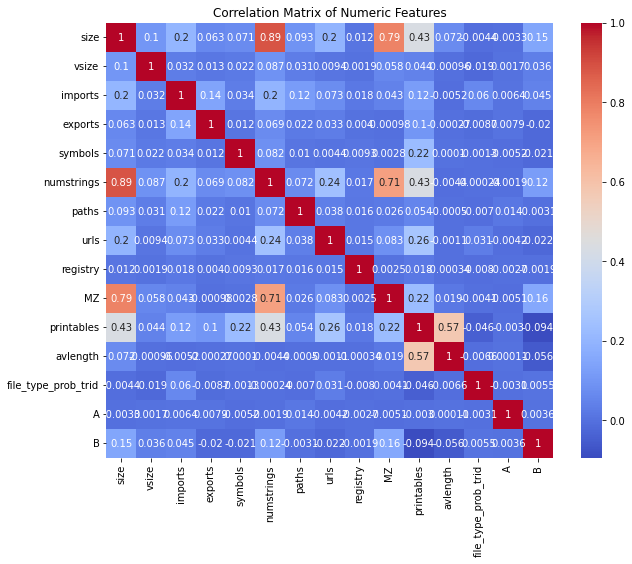

In [1429]:
# Now we analyze the relationships between the numeric features:
# Scatter plots
#sns.pairplot(data=X_train[numeric_features])
#plt.show()

# Correlation matrix
correlation_matrix = X_train[numeric_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

**Conclusion:** <br> We can recognize a very high correlation of 0.89 between the features 'size' and 'numstrings'. In addition, we find high correlation of 0.79 between the features 'size' ans 'MZ'. According the information we have on the features it make sence. We will consider to remove one of them.

In [1430]:
# We want to visualize the categorial features, but first we want to discover how many classes each categorial feature has :

# Calculate unique value counts for each categorical feature
unique_value_counts = X_train[categorical_features].nunique()
# Create a dictionary with feature names and unique value counts
unique_value_counts_dict = dict(unique_value_counts)

# Print the dictionary
for feature, count in unique_value_counts_dict.items():
    print(f"{feature}: {count} unique values")

sha256: 48000 unique values
has_debug: 2 unique values
has_relocations: 2 unique values
has_resources: 2 unique values
has_signature: 2 unique values
has_tls: 2 unique values
file_type_trid: 88 unique values
C: 7 unique values


According to the results, we choose to draw a bar plot to all the categorial features besides 'Sha256' and 'file_type_trid'. <br>From the 'Feature Information' file we know that 'sha256' represent the unique identifier for each file and because it has 48000 uniqe values, meanning it doesn't have missing values. Therefore, we decided to not plot this feature. in addition we decided not to plot 'file_type_trid' feature because this feature represent the file type and also has too many uniqe values:

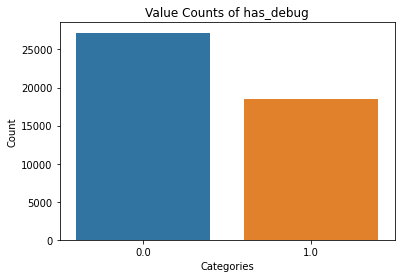

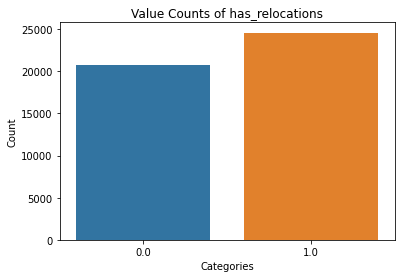

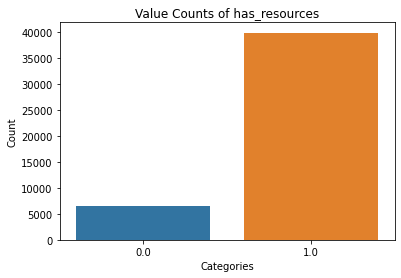

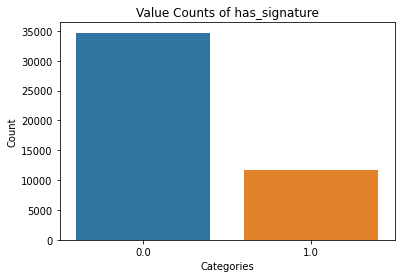

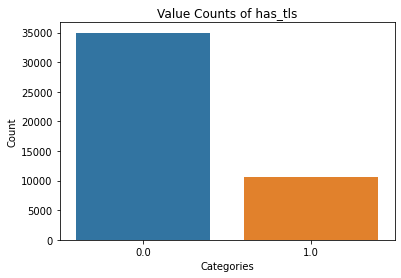

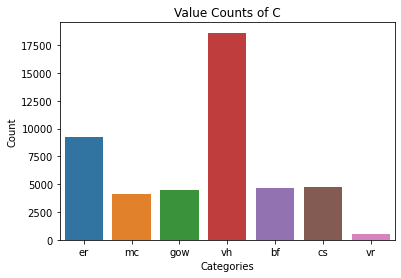

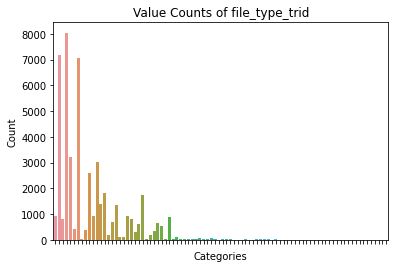

In [1431]:
# Exclude specific features
exclude_features = ['sha256', 'file_type_trid']

# Plot value counts for each categorical feature
for feature in categorical_features:
    if feature not in exclude_features:
        sns.countplot(data=X_train, x=feature)
        plt.title(f"Value Counts of {feature}")
        plt.xlabel('Categories')
        plt.ylabel('Count')
        plt.show()
# Plot file_type_trid feature without the names of the 88 unique values of them
sns.countplot(data=X_train, x="file_type_trid")
plt.title(f"Value Counts of file_type_trid")
plt.xlabel('Categories')
plt.ylabel('Count')
plt.gca().set_xticklabels([])
plt.show()


**Conclusion:** <br>
The value count analysis of categorical features reveals the presence of rare unique values with low frequency in the dataset. These rare categories need to be carefully considered during analysis and modeling to ensure accurate predictions.

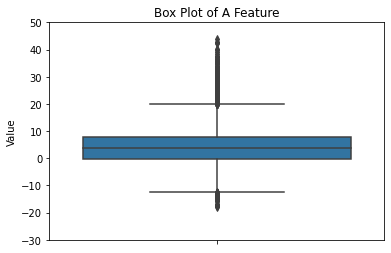

In [1432]:
# Create a boxplot with Seaborn
sns.boxplot(data=X_train, y='A')
plt.title('Box Plot of A Feature')
plt.ylabel('Value')

# Set the y-axis scale to 10
plt.ylim(-30, 50)  # Adjust the range based on your data

plt.show()

The decision to plot a box plot for feature A was based on the observation of a normal distribution in the histogram. Box plots assume a normal distribution and provide a useful tool for detecting outliers. By examining the box plot, we can identify any data points that fall significantly outside the expected range, helping us to identify potential outliers in feature A.

## PART2 - PREPROCESSING

**Finding Missing Values**

In [1433]:
# Finding the missing values in each feature in our train set:
X_train.isnull().sum()

sha256                    0
size                      0
vsize                  1532
imports                1409
exports                1679
has_debug              2355
has_relocations        2659
has_resources          1582
has_signature          1555
has_tls                2350
symbols                2099
numstrings             2175
paths                  2942
urls                   1874
registry               2020
MZ                     2460
printables             2147
avlength               2184
file_type_trid            0
file_type_prob_trid       0
A                      2959
B                      3075
C                      1659
dtype: int64

In [1434]:
# Checking if there are samples with more than half missing values in order to remove them :
X_train[(X_train.isnull().sum(axis=1)) > 11]

,sha256,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,...,urls,registry,MZ,printables,avlength,file_type_trid,file_type_prob_trid,A,B,C


No samples to remove 

In [1435]:
# Finding the missing values in each feature in our test set:
X_test.isnull().sum()

sha256                   0
size                     0
vsize                  403
imports                330
exports                414
has_debug              572
has_relocations        665
has_resources          379
has_signature          382
has_tls                548
symbols                557
numstrings             543
paths                  718
urls                   475
registry               505
MZ                     629
printables             592
avlength               573
file_type_trid           0
file_type_prob_trid      0
A                      745
B                      676
C                      392
dtype: int64

**Detecting Outliers using tools that were not taught in the course** <br> 

From the visual inspection that we did in part1, in some of the features we found individual data points that are far away from the bulk of the data, which we suspect them as outliers.
We will check in 2 diffrent approaches in order to detect outliers and remove them.

**1. Z-score Method<br>**
**Detecting outlieres with z-score method for normal distribution - features 'A' :<br>**
the z-score is a statistical measure that quantifies how far a data point deviates from the mean of a distribution. It indicates the number of standard deviations a data point is away from the mean.<br>
The formula of z-score is: z = (x - μ) / σ, where z is the z-score, x is the data point, μ is the mean, and σ is the standard deviation.<br>
The z-score allows to standardize and compare data points across different distributions. In outlier detection, if a data point has a z-score that is significantly different from zero (typically greater than a certain threshold, e.g., 2 or 3), it suggests that the data point is an outlier.<br>
By using z-scores, we can identify data points that are unusually far from the mean and are likely to be outliers. This approach is based on the assumption that the data follows a normal distribution.<br>

We chose to use the z-score method in outlier detection because it is widely used, simple, and easy to interpret.<br> Additionally, z-score relies on the assumption of normal distribution, so we applied it to feature A, which we discovered during exploration to be similar to a normal distribution.<br> By using the z-score, we could identify and handle outliers in feature A, which helped in reducing the influence of noisy data points and improving the model's performance.<br>
We chose a threshold of 3 for the z-score method because it is a commonly used value in outlier detection. A z-score of 3 corresponds to approximately three standard deviations away from the mean. This threshold is often considered a conservative choice, capturing data points that deviate significantly from the average and are considered extreme outliers.<br> By setting the threshold at 3, we aimed to identify and address the most extreme and potentially influential outliers in feature A.

In [1436]:
def remove_outliers_zscore(X_train, y_train, feature, threshold=3):
    # Calculate the z-scores for the feature in the training data
    z_scores = (X_train[feature] - X_train[feature].mean()) / X_train[feature].std()
    # Identify outliers based on the z-scores exceeding the threshold
    outliers = X_train[np.abs(z_scores) > threshold]
    # Print the number of outliers found in the feature
    print('Number of ouliers in feature A :',outliers.shape[0])
    # Remove the outliers from the training data
    X_train = X_train.drop(outliers.index)
    y_train = y_train.drop(outliers.index)
    return X_train, y_train

X_train, y_train = remove_outliers_zscore(X_train, y_train, 'A')

Number of ouliers in feature A : 310


We found and removed 310 outliers in 'A' feature

**2. Local Outlier Factor algorithm (LOF) Algorithm**<br>
The LOF algorithm is an unsupervised anomaly detection technique that measures the local density deviation of a data point in relation to its neighboring points. It can effectively identify outliers that exhibit different characteristics compared to their surrounding data points. One advantage of using LOF is that it does not assume any specific distribution of the data, making it applicable even when the feature's distribution is unknown like in our case.<br>

In order to prepare the data for LOF algorithm, we will first fill missing values and perform mathematical trasforamtions. <br>
* we utilized the SimpleImputer class to handle missing values. <br>The SimpleImputer provides a straightforward approach to filling in missing values based on a specified strategy.<br> For the numeric features, we opted for the "mean" strategy, which replaces the missing values with the average of the available values. By using the mean value, we can preserve the overall distribution and central tendency of the data. <br>For the categorical features, we chose the "most frequent" strategy, which fills in the missing values with the most commonly occurring category.By using the most frequent category, we can maintain the majority class distribution and preserve the existing patterns within the categorical data.<br> By using these strategies, we ensured that the missing values were appropriately handled and the data was ready for outlier detection using the LOF algorithm.

In [1437]:
def fill_missing_values_numeric(X_train, X_test, numeric_features):
    # Create a numeric imputer to fill missing values with the mean
    numeric_imputer = SimpleImputer(strategy='mean')
    # Fill missing values in the numeric features of the training data
    X_train[numeric_features] = numeric_imputer.fit_transform(X_train[numeric_features])
    # Fill missing values in the numeric features of the test data based on the train data
    X_test[numeric_features] = numeric_imputer.transform(X_test[numeric_features])
    return X_train, X_test

X_train, X_test = fill_missing_values_numeric(X_train, X_test, numeric_features)

In [1438]:
def fill_missing_values_categorical(X_train, X_test, categorical_features):
    # Create a categorical imputer to fill missing values with the most frequent category
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    # Fill missing values in the categorical features of the training data
    X_train[categorical_features] = categorical_imputer.fit_transform(X_train[categorical_features])
    # Fill missing values in the categorical features of the test data based on the train data
    X_test[categorical_features] = categorical_imputer.transform(X_test[categorical_features])
    return X_train, X_test

X_train, X_test = fill_missing_values_categorical(X_train, X_test, categorical_features)

* Mathematical Manipulation - Log Transformation <br>
Based on the findings from the exploration part, where we observed that certain features have very large values and substantial differences between the minimum and maximum values, we will now proceed with applying the logarithm function, on these identified features. The logarithm transformation is commonly used to compress the scale of variables with large ranges and reduce the impact of extreme values.

In [1439]:
def apply_log_transformation(X_train, X_test, log_features):
    for feature in log_features:
        # Apply logarithmic transformation to each specified feature in the training and test data
        X_train[feature] = np.log(X_train[feature])
        X_test[feature] = np.log(X_test[feature])
    return X_train, X_test

X_train, X_test = apply_log_transformation(X_train, X_test, ['size', 'vsize', 'printables'])

By applying the LOF algorithm, we are able to detect and handle outliers in the specified features. This impacted the model by improving its robustness to anomalies and potentially enhancing its performance by reducing the influence of outliers on the training process:

In [1440]:
def remove_outliers_lof(X_train, y_train, selected_features):
    # Create a Local Outlier Factor (LOF) model
    lof = LocalOutlierFactor(n_neighbors=30, contamination=0.08)
    # Detect outlier labels based on the LOF model
    outlier_labels = lof.fit_predict(X_train[selected_features])
    # Identify outliers based on the outlier labels
    outliers = X_train[outlier_labels == -1]
    # Print the number of outliers found in the feature size
    print('Number of ouliers in feature size :',outliers.shape[0])
    # Remove the outliers from the training data
    X_train = X_train.drop(outliers.index)
    y_train = y_train.drop(outliers.index)
    return X_train, y_train

X_train, y_train = remove_outliers_lof(X_train, y_train, ['size', 'imports', 'exports', 'symbols', 'urls', 'MZ', 'printables'])
print(X_train.shape, y_train.shape)

Number of ouliers in feature size : 3816
(43874, 23) (43874,)


We used the Local Outlier Factor (LOF) algorithm to identify outliers in specific features: 'size', 'imports', 'exports', 'symbols', 'urls', 'MZ', and 'printables'. <br>
These features were found to have outliers based on the visualization analysis. However, we decided not to remove outliers in the 'numstrings' feature due to its high correlation (0.89) with the 'size' feature, as indicated by the correlation map.

For the LOF algorithm, we set the n_neighbors parameter to 30 and the contamination parameter to 0.08. The n_neighbors parameter determines the number of neighboring points used to estimate local density, while the contamination parameter represents the expected proportion of outliers in the data. By choosing these values, we aimed to strike a balance between accurately estimating density and specifying the threshold for outlier classification.
The selection of these parameter values was based on experimentation to achieve a suitable balance between outlier detection accuracy and model performance.<br>
After applying the LOF algorithm, we obtained outlier labels and scores for each data point. To ensure that the model is not influenced by potentially anomalous data points, we removed the corresponding rows from the training set (X_train and y_train). By removing these outliers, we improve the model's ability to learn patterns and make accurate predictions, as it can now focus on the majority of the data that represents the underlying patterns and relationships.

**Feature Exclusion**<br>
As part of the dimensionality reduction process, we will make the following feature exclusions:<br>
Removing 'sha256' and 'numstrings' Features.<br>
The 'sha256' feature serves as a unique identifier for each sample and does not provide meaningful information about the samples themselves. Therefore, we have decided to exclude it from our analysis to focus on the relevant features.
Additionally, the 'numstrings' feature exhibits a high correlation with the 'size' feature in the dataset. Highly correlated features can introduce redundancy and increase the dimensionality of the data. To address this, we have chosen to eliminate the 'numstrings' feature to reduce the "curse of dimensionality."

By removing these features, we aim to streamline our analysis, reduce redundancy, and prioritize the most informative features. These actions are essential in preparing the data for subsequent analysis and modeling steps, which we will delve into further.

In [1441]:
# Create function which deletes certain features:
def drop_features(X, features_to_drop):
    X = X.drop(columns=features_to_drop)
    return X

# Update X_train 
X_train = drop_features(X_train, ['sha256', 'numstrings'])
# Update X_test
X_test = drop_features(X_test, ['sha256', 'numstrings'])
# Updating our features lists
numeric_features = numeric_features.difference(['numstrings'])
categorical_features = categorical_features.difference(['sha256'])

**Feature Engineering - Creating New Features**<br>
1. Difference between Size and VSize:<br>
Rationale: This new feature aims to capture the difference between the "Size" and "VSize" variables. By examining this difference, we can potentially identify the presence of compression or padding techniques employed in the file. These techniques are often indicative of malicious behavior and can provide valuable insights for our analysis.

2. Ratio between Size and VSize:<br>
Rationale: The ratio between the "Size" and "VSize" variables offers information about the packing or compression status of the file. By calculating this ratio, we can determine if the file has been packed or compressed, which is another relevant characteristic to consider when identifying malicious files.

3. Imports minus Exports:<br>
Rationale: This newly created feature represents the difference between the number of imports and exports in the file. By evaluating the balance between incoming and outgoing function calls, we can potentially uncover patterns associated with malicious files. This feature provides insights into the behavior and interactions of the file with other components, contributing to our understanding of its malicious nature.

4. Ratio of "avlength" divided by "size":<br>
Rationale: The ratio of "avlength" (average string length) divided by "size" introduces a measure of the average string length relative to the file size. This feature provides insights into the compactness or density of malicious files. We specifically chose to create this feature using "avlength" because its histogram predominantly contains values associated with malicious files. By incorporating this new feature, we aim to enhance the discriminatory power of our model and improve its performance.

Through these feature engineering techniques, we aim to extract valuable information from the existing variables, enabling us to better understand and identify malicious files:

In [1442]:
def create_additional_features(X_train, X_test):
    # Create additional features based on calculations using existing features

    # Calculate the absolute difference between size and vsize
    X_train['size_vsize_diff'] = abs(X_train['size'] - X_train['vsize'])
    X_test['size_vsize_diff'] = abs(X_test['size'] - X_test['vsize'])

    # Calculate the ratio of size to vsize
    X_train['size_vsize_ratio'] = X_train['size'] / X_train['vsize']
    X_test['size_vsize_ratio'] = X_test['size'] / X_test['vsize']

    # Calculate the absolute difference between imports and exports
    X_train['import_export_diff'] = abs(X_train['imports'] - X_train['exports'])
    X_test['import_export_diff'] = abs(X_test['imports'] - X_test['exports'])

    # Calculate the ratio of avlength to size
    X_train['avlength_size_ratio'] = X_train['avlength'] / X_train['size']
    X_test['avlength_size_ratio'] = X_test['avlength'] / X_test['size']

    return X_train, X_test

X_train, X_test = create_additional_features(X_train, X_test)

In [1443]:
# Ratio of Imports to Exports in the train and test datasets
X_train['import_export_ratio'] = X_train['imports'] / X_train['exports']
inf_count = np.isinf(X_train['import_export_ratio']).sum()
print("Number of 'inf' values in import_export_ratio:", inf_count)

Number of 'inf' values in import_export_ratio: 31776


We attempted to create the above feature called "Ratio of Imports to Exports" to capture the dependency or external interaction of the file, which could indicate its maliciousness. <br>
However, after calculating the ratio, we discovered that a large number of values resulted in 'inf' (infinity) due to division by zero.<br>
With 31,776 'inf' values and a high prevalence of zeros, we decided to drop this feature from our workflow. Despite its failure, we kept this attempt as part of our analysis and experimentation process.

In [1444]:
# Drop the import_export_ratio feature from the train data
X_train = drop_features(X_train, 'import_export_ratio')

In [1445]:
# Updae the 'numeric_features' with the new features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

<b>Normalization

In our project, the data is not normalized. Normalization refers to the process of scaling and transforming the data to a common scale or distribution. We need to normalize the data because it can be important in many machine learning problems for the following reasons:<br>
* Eliminating scale differences: Different features in the dataset may have different scales. Normalizing the data ensures that all features are on a similar scale.<br>
* Improving convergence of optimization algorithms: Many machine learning algorithms rely on optimization techniques to find the optimal model parameters. Normalizing the data can help improve the convergence of these optimization algorithms by providing a well-conditioned problem.<br>
* Facilitating comparison of features: Normalization enables fair comparison and evaluation of different features. It ensures that each feature contributes proportionally to the learning process and avoids bias towards features with larger magnitudes.<br>
* Handling distance-based algorithms: Distance-based algorithms, such as KNN, are sensitive to the scale of the features. Normalizing the data allows these algorithms to correctly measure the distances and similarities between samples.<br>
* Ensuring robustness to outliers: Normalization can help reduce the impact of outliers by bringing the data within a smaller range. Outliers can have a significant effect on some algorithms, and normalization helps to mitigate this effect.<br>

In conclusion, normalizing the data is important in our problem as it helps address the issues mentioned above and can improve the performance and reliability of our machine learning models.

* We want to normalize each feature in a way that best suits it. We will start with the numeric features for which we havne't identified a particular distribution, using Min-Max Scaling:

In [1446]:
def normalize_features(X_train, X_test, numeric_features, exclude_features):
    # Create a MinMaxScaler to normalize the selected numeric features
    scaler = MinMaxScaler()
    # Select the features to be normalized (excluding the excluded features)
    selected_features = [feature for feature in numeric_features if feature not in exclude_features]
    # Normalize the selected features in the training data
    X_train[selected_features] = scaler.fit_transform(X_train[selected_features])
    scaler.fit(X_train[selected_features])
    # Normalize the selected features in the test data based on the train data
    X_test[selected_features] = scaler.transform(X_test[selected_features])
    return X_train, X_test

X_train, X_test = normalize_features(X_train, X_test, numeric_features, ['B'])

* Normalize feature 'B': <br>
We decided to normalize the 'B' feature using the Box-Cox transformation. This method is effective for normalizing skewed data and can handle both positive and negative skewness. The Box-Cox transformation applies a power transformation to the data, with the power parameter lambda automatically determined. By applying the Box-Cox transformation to the 'B' feature in X_train, we will normalize its values and improve the distribution.

In [1447]:
def apply_boxcox_transformation(X_train, X_test, feature):
    # Apply Box-Cox transformation to the specified feature in the training data
    transformed_B, lambda_ = boxcox(X_train[feature])
    X_train[feature] = transformed_B
    # Apply Box-Cox transformation to the specified feature in the test data using the lambda value from training data
    transformed_B_test = boxcox(X_test[feature], lmbda=lambda_)
    X_test[feature] = transformed_B_test
    return X_train, X_test

X_train, X_test = apply_boxcox_transformation(X_train, X_test, 'B')

* **Target Encoding - a technique which was not covered in our course**<br>

Next, we will proceed with the normalization of the categorical features: "file_type_trid" and "C". However, it's important to note that the remaining categorical features are binary, meaning their values are already restricted to 0 and 1. As a result, there is no need for further scaling or normalization of these features.
When it comes to normalizing categorical features, we have chosen to use target encoding. <br>
Target encoding is a technique that involves replacing categorical values with the mean of the target variable for each category. It provides a way to represent categorical information in a numerical format that can be more easily processed by machine learning algorithms.

It's worth mentioning that target encoding was not covered in our course, but we have decided to explore and utilize it based on its potential benefits in capturing valuable information from categorical features.
Furthermore, we will handle unseen data by ensuring that our code utilizes the filtered values from the training dataset. This approach helps to maintain consistency and avoid any leakage of information from the test data into the training process.

In [1448]:
def target_encode_columns(X_train, X_test, y_train, columns_to_encode):
    # Iterate over each column to be target encoded
    for column in columns_to_encode:
        # Create a dictionary to store the target mean values for each category
        target_means = {}

        # Iterate over each category in the training data
        for category in X_train[column].unique():
            # Calculate the mean target value for instances with the current category
            mean_target = y_train[X_train[column] == category].mean()

            # Store the mean target value in the dictionary
            target_means[category] = mean_target

        # Replace the categorical values with the mean target values in the training data
        X_train[column] = X_train[column].map(target_means)

    # Iterate over each column again to handle unseen categories in the test data
    for column in columns_to_encode:
        # Calculate the overall mean target value in the training data
        overall_mean_target = y_train.mean()

        # Replace the unseen categories in the test data with the overall mean target value
        X_test[column] = X_test[column].map(target_means).fillna(overall_mean_target)

    return X_train, X_test
    
columns_to_encode = ["file_type_trid", "C"]    
X_train, X_test = target_encode_columns(X_train, X_test, y_train, columns_to_encode)
X_train.shape

(43874, 25)

In [1449]:
## Initially, one-hot encoding with a threshold was used to encode the categorical features. Later on, we changed into Target incoding.
# This code is not part of the final work flow ##

# Define the threshold according to 6% of the X_train in order to create new columns 
#threshold = 2480

# List of categorical features to encode
#categorical_columns = ["file_type_trid", "C"]

# Iterate over each categorical column
#for column in categorical_columns:
    # Get the unique values and their counts for the column in the training dataset
    #unique_values_counts = X_train[column].value_counts()
    
    # Filter unique values based on the threshold
    #filtered_values = unique_values_counts[unique_values_counts > threshold].index.tolist()
    
    # One-hot encode the filtered values in the training dataset
    #for value in filtered_values:
        # Create a new binary column indicating whether the value matches
        #new_column_name = f"{column}_{value}"
        #X_train[new_column_name] = (X_train[column] == value).astype(int)
    
    # Create a new column for unknown values in the training dataset
    #unknown_column_name = f"{column}_unknown"
    #X_train[unknown_column_name] = (~(X_train[column].isin(filtered_values))).astype(int)
    
    # Drop the original categorical column from the training dataset
    #X_train.drop(column, axis=1, inplace=True)
    
    # One-hot encode the filtered values in the test dataset and handle unknown values
    #for value in filtered_values:
        # Create a new binary column indicating whether the value matches
        #new_column_name = f"{column}_{value}"
        #X_test[new_column_name] = (X_test[column] == value).astype(int)
    
    # Create a new column for unknown values in the test dataset
    #X_test[unknown_column_name] = (~(X_test[column].isin(filtered_values))).astype(int)
    
    # Drop the original categorical column from the test dataset if present
    #if column in X_test.columns:
        #X_test.drop(column, axis=1, inplace=True)
    #else:
        # If the column is not present in the test dataset, add a column of zeros
        #X_test[new_column_name] = 0

# Print the shape of the encoded datasets
#print("Train dataset shape:", X_train.shape)
#print("Test dataset shape:", X_test.shape)

<b>Dimensionality Reduction

High dimensionality refers to a large number of features in a dataset. In our opinion, the dimensionality of the problem is too great because it leads to the curse of dimensionality, which can cause several issues. With a large number of features, the available data becomes sparse, making it difficult to find meaningful patterns and relationships. Additionally, the computational complexity increases exponentially, making analysis and modeling more time-consuming and resource-intensive.<br>
High dimensionality also raises the risk of overfitting, where models become overly complex and perform poorly on new data. Interpretation and visualization become challenging as well, as it becomes harder to comprehend and visualize data in high-dimensional spaces. Therefore, reducing the dimensionality through techniques like feature selection or dimensionality reduction is often necessary to address these problems.
To recognize that the dimensions of the problem are too large, we can consider the following factors:
* The ratio of the number of observations (samples) to the number of features
* Computational limitations
* Lack of meaningful patterns or predictive power

**Dimensionality reduction by Backward Selection technique** <br>
Backward selection is a feature selection method used for dimensionality reduction in machine learning. It starts with an initial model that includes all the available features, and then iteratively removes features from the model until a desired subset of features is obtained.

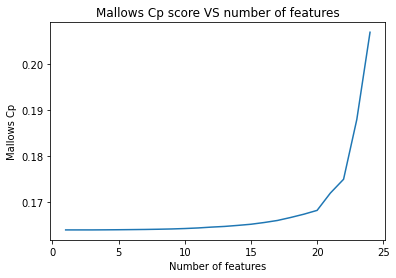

Number of selected features by backward: 24
Selected features: ['A', 'B', 'C', 'MZ', 'avlength_size_ratio', 'exports', 'file_type_prob_trid', 'file_type_trid', 'has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls', 'import_export_diff', 'imports', 'paths', 'printables', 'registry', 'size', 'size_vsize_diff', 'size_vsize_ratio', 'symbols', 'urls', 'vsize']


In [1450]:
# Backward Selection #
def get_sigma_hat_squared(X: pd.DataFrame, y: pd.Series) -> float:
    linear_reg = LinearRegression()
    linear_reg.fit(X, y)
    y_pred = linear_reg.predict(X)
    rss = ((y - y_pred) ** 2).sum()
    all_features = X.shape[1]
    n = X.shape[0]
    sigma_hat_squared = rss / (n - all_features - 1)
    return sigma_hat_squared

def get_mallows_cp_score(X: pd.DataFrame, y: pd.Series, sigma_hat_squared: float) -> float:
    n = X.shape[0]
    d = X.shape[1]
    linear_reg = LinearRegression()
    linear_reg.fit(X, y)
    y_pred = linear_reg.predict(X)
    mse = mean_squared_error(y, y_pred)
    mallows_cp = mse + 2 * ((d + 1) / n) * sigma_hat_squared
    return mallows_cp

def remove_feature(X: pd.DataFrame, y: pd.Series, current_features: List[str], sigma_hat_squared: float) -> Dict:
    best_features_lst = None
    best_score = None
    for feature in current_features:
        reduced_features = [f for f in current_features if f != feature]
        reduced_col = X[reduced_features]
        cp_score = get_mallows_cp_score(reduced_col, y, sigma_hat_squared)
        if best_score is None or cp_score < best_score:
            best_score = cp_score 
            best_features_lst = reduced_features
    return {'features': sorted(best_features_lst), 'score': best_score}

def backward_selection(X: pd.DataFrame, y: pd.Series) -> List[str]:
    sigma_hat_squared = get_sigma_hat_squared(X, y)
    current_features = list(X.columns)
    models_lst = []
    while len(current_features) > 1:
        model = remove_feature(X, y, current_features, sigma_hat_squared)
        current_features = model['features']
        models_lst.append(model)
    
    scores_lst = [x['score'] for x in models_lst]
    plt.plot(range(1, len(scores_lst) + 1), scores_lst)
    plt.xlabel("Number of features")
    plt.ylabel("Mallows Cp")
    plt.title("Mallows Cp score VS number of features")
    plt.show()

    best_model = min(models_lst, key=lambda x: x['score'])
    best_features = best_model['features']
    return sorted(best_features)

# Call the backward_selection function with pandas DataFrames
features_bk = backward_selection(X_train, y_train)
print(f'Number of selected features by backward: {len(features_bk)}')
print('Selected features:', features_bk)

the number of features decreased from 25 to 24 after the backward selection process, it indicates that the reduction in dimensionality had a positive effect on the model.<br>
By applying backward selection, we systematically removed one feature at a time based on its impact on the Mallows Cp score. The Mallows Cp score measures the model's prediction error and complexity, with lower scores indicating better performance. The iterative process of removing the least significant feature led to a final set of 24 features that achieved the lowest Mallows Cp score.

The reduction in dimensionality can bring several benefits to the model, such as:<br>
- Improved generalization: By removing irrelevant or redundant features, the model becomes more focused on the most informative attributes, reducing overfitting and improving its ability to generalize well to unseen data.
- Increased interpretability: With fewer features, it becomes easier to interpret the model and understand the relationships between the selected features and the target variable.
- Enhanced computational efficiency: Having fewer features reduces the computational burden during training and prediction, allowing for faster model development and inference.

In summary, the backward selection process effectively reduced the dimensionality from 25 to 24 features, resulting in improved model performance and potential benefits in terms of generalization, interpretability, and computational efficiency.

## PART3 - MODELING

Initial Models : KNN and Logistic Regression. <br>
Advanced Models: Ada Boosting and SVM.<br>
We will start with performing hyperparameter tuning for each of the models above using grid search:

In [1451]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train.loc[:, features_bk], y_train, test_size=0.2, random_state=42)

K-Nearest Neighbors (KNN):

In [1452]:
# Define the hyperparameter grid
param_grid = {'n_neighbors': [5, 8, 9, 11, 13]}

# Create the KNN classifier
knn = KNeighborsClassifier()

# Perform grid search cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params_knn = grid_search.best_params_
print("Best Hyperparameters for KNN:", best_params_knn)

Best Hyperparameters for KNN: {'n_neighbors': 5}


<b>The meaning of the hyper parameters in the KNN model and how they affect the model in terms of variance and bias :

The hyperparameter we chose to change for the KNN (K-Nearest Neighbors) model is n_neighbors. This parameter determines the number of neighbors considered for classification. By varying this parameter, we can control the complexity of the model and its bias-variance trade-off.

When n_neighbors is set to a smaller value, such as 5, the model becomes more flexible and can capture intricate patterns in the data. This reduces bias as the decision boundaries are more closely fitted to the training data. However, a lower value also increases the variance because the model becomes more sensitive to noise and outliers in the data. This can lead to overfitting and decreased generalization on unseen data.

On the other hand, when n_neighbors is set to a larger value, such as 13, the model becomes less flexible and the decision boundaries become smoother. This increases bias as the model assumes a more generalized representation of the data. By considering more neighbors, the model can make more robust predictions and reduce the influence of individual data points. However, setting a higher value also reduces variance as the model becomes less sensitive to noise and outliers.

During the grid search cross-validation, we tested different values of n_neighbors (5, 8, 9, 11, and 13) to find the best-performing hyperparameter value. The grid search evaluated the model's performance on different folds of the training data, allowing us to identify the optimal value of n_neighbors that balances bias and variance.

The best hyperparameter value (n_neighbors) that selected through the grid search is 5. It represents the configuration that achieved the highest performance based on the chosen evaluation metric. By choosing the best hyperparameter value, we aimed to strike a balance between bias and variance, leading to a well-performing KNN model that can generalize well to unseen data.

We used the default value for the 'weights' parameter which is 'uniform'.
When 'uniform' is set as the value for weights, all points in each neighborhood are weighted equally, and the majority class of the nearest neighbors is used for classification. This means that each neighbor contributes equally to the decision-making process.

Logistic Regression:

In [1453]:
# Define the hyperparameter grid
param_grid = {'C': [0.01,0.1, 1]}

# Create the Logistic Regression classifier
logistic_regression = LogisticRegression(solver='liblinear')

# Perform grid search cross-validation
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params_lg = grid_search.best_params_
print("Best Hyperparameters for Logistic Regression:", best_params_lg)

Best Hyperparameters for Logistic Regression: {'C': 1}


<b>The meaning of the hyper parameters in the Logistic Regression model and how they affect the model in terms of variance and bias :

In logistic regression, we focused on changing the hyperparameter 'C', which represents the inverse of the regularization strength. 'C' controls the amount of regularization applied to the model. A smaller 'C' value increases regularization, reducing overfitting and decreasing variance but potentially increasing bias. Conversely, a larger 'C' value decreases regularization, allowing the model to fit the training data more closely, potentially increasing variance.

Through grid search cross-validation, we tested different 'C' values ([0.01, 0.1, 1]) to find the optimal balance between bias and variance. The best hyperparameters, determined by grid search, strike a balance between model complexity and generalization performance. Additionally, logistic regression employs a penalty term to the loss function, with the 'liblinear' solver being used in this case.
The best hyperparameter value (C) that selected through the grid search is 1.

In [1454]:
## RANDOM FOREST ##
# At first we did grid search on Random Forest Model and the the best hyperparameters were- 'max_depth': None and 'n_estimators': 120.
# But then we changed to AdaBoost so this code is not part of the work flow

# Define the hyperparameter grid
#param_grid = {'n_estimators': [100, 120, 180], 'max_depth': [5, 10, None]}

# Create the Random Forest classifier
#random_forest = RandomForestClassifier()

# Perform grid search cross-validation
#grid_search = GridSearchCV(random_forest, param_grid, cv=5)
#grid_search.fit(X_train, y_train)

# Get the best hyperparameters
#best_params_rf = grid_search.best_params_
#print("Best Hyperparameters for Random Forest:", best_params_rf)

Ada Boost:

In [1455]:
# Define the hyperparameter grid
param_grid = {'n_estimators': [150,200,250], 'learning_rate': [1.0,1.5,1.8]}

# Create the AdaBoost classifier
adaboost = AdaBoostClassifier()

# Perform grid search cross-validation
grid_search = GridSearchCV(adaboost, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params_adaboost = grid_search.best_params_
print("Best Hyperparameters for AdaBoost:", best_params_adaboost)

Best Hyperparameters for AdaBoost: {'learning_rate': 1.5, 'n_estimators': 250}


<b>The meaning of the hyper parameters in the AdaBoost model and how they affect the model in terms of variance and bias :

The hyperparameter grid specified for AdaBoost consists of two parameters: n_estimators and learning_rate.

n_estimators refers to the number of weak classifiers used in the boosting process. In the grid search, the values tested were 120, 180, and 200. Increasing the number of estimators can capture more complex patterns in the data, but it also increases the risk of overfitting.

learning_rate represents the contribution of each weak classifier to the final ensemble. The values tested in the grid search were 0.5, 1.0, and 1.5. A smaller learning rate emphasizes the correction of misclassifications, leading to improved robustness, but it requires more estimators to achieve comparable performance.
These hyperparameters play a role in the bias-variance trade-off. A higher n_estimators value can reduce bias but may increase variance and overfitting. On the other hand, a smaller learning_rate improves generalization but necessitates more estimators for convergence.

To summarize, the values specified for n_estimators and learning_rate in the grid search allow for exploration of different levels of model complexity and regularization. The optimal combination of these hyperparameters depends on the specific dataset and the desired trade-off between bias and variance.

in addition to the n_estimators and learning_rate, the code does not specify any other hyperparameters explicitly, which means the default values for those hyperparameters will be used. The default hyperparameter values for AdaBoostClassifier in scikit-learn are as follows:
- base_estimator: The default base estimator for classification tasks is a decision tree with a maximum depth of 1 (DecisionTreeClassifier(max_depth=1)).<br>
- algorithm: The default algorithm for boosting is the SAMME.R algorithm, which is an improved variant of SAMME (Stagewise Additive Modeling using a Multi-class Exponential loss function).<br>
- random_state: The default value is None, which means the random number generator used by the algorithm is the RandomState instance used by np.random.<br>
- loss: The default loss function for classification is the exponential loss ('exponential'), which is commonly used in AdaBoost.

Support Vector Machine (SVM):

In [1456]:
# Define the hyperparameter grid
param_grid = {'C': [1, 10,15]}

# Create the SVM classifier
svm = SVC()

# Perform grid search cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params_svm = grid_search.best_params_
print("Best Hyperparameters for SVM:", best_params_svm)

Best Hyperparameters for SVM: {'C': 15}


<b>The meaning of the hyper parameters in the SVM model and how they affect the model in terms of variance and bias :

In the SVM (Support Vector Machine) model, we focused on changing the hyperparameter 'C'.

'C' is the regularization parameter in SVM, also known as the penalty parameter. It controls the trade-off between achieving a low training error (low bias) and allowing more margin violations (high variance).

A smaller value of 'C' leads to a larger margin and a simpler decision boundary, which may result in higher bias but lower variance. Conversely, a larger value of 'C' allows for a smaller margin and a more complex decision boundary, potentially reducing bias but increasing variance.

By specifying different values for 'C' ([1, 10, 15]), we performed grid search cross-validation to find the optimal value of 'C' that minimizes the error and achieves a good balance between bias and variance.
The best hyperparameter value (C) that selected through the grid search is 15.

We chose the default value for the 'kernel' hyperparameter in the SVM's which is 'rbf'.
The 'rbf' kernel is one of the most commonly used kernels in SVM models. It is a popular choice because it can effectively capture complex, non-linear relationships between the data points. The 'kernel' hyperparameter determines the type of kernel function used in the SVM model.

Advanced Models:

**Feature importances:** <br>
Feature importance is a crucial aspect in machine learning models as it helps us understand the contribution of each feature to the model's success. By analyzing the feature importance, we can uncover the key drivers behind the model's predictions and gain insights into the underlying relationships between the features and the target variable.
In this analysis, the feature importance scores were obtained using Ada Boost algorithm. Ada Boost calculates feature importance based on the model's performance and provides a robust measure of feature importance:

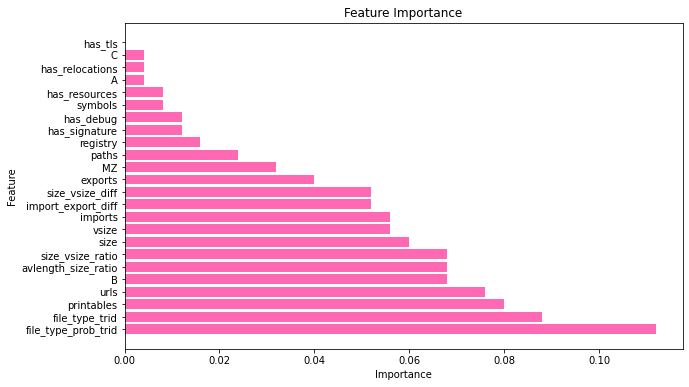

                Feature  Importance
6   file_type_prob_trid       0.112
7        file_type_trid       0.088
16           printables       0.080
22                 urls       0.076
1                     B       0.068
4   avlength_size_ratio       0.068
20     size_vsize_ratio       0.068
18                 size       0.060
23                vsize       0.056
14              imports       0.056
13   import_export_diff       0.052
19      size_vsize_diff       0.052
5               exports       0.040
3                    MZ       0.032
15                paths       0.024
17             registry       0.016
11        has_signature       0.012
8             has_debug       0.012
21              symbols       0.008
10        has_resources       0.008
0                     A       0.004
9       has_relocations       0.004
2                     C       0.004
12              has_tls       0.000


In [1457]:
adaboost = AdaBoostClassifier(n_estimators=best_params_adaboost['n_estimators'], learning_rate=best_params_adaboost['learning_rate'])  # Set the desired number of estimators and learning rate
adaboost.fit(X_train, y_train)

# Get the feature importances
importances = adaboost.feature_importances_

# Create a DataFrame to store feature importances
feature_importances = pd.DataFrame({'Feature': features_bk, 'Importance': importances})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='hotpink')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Print the feature importances
print(feature_importances)


Based on the feature importance scores, the top features contributing to the success of the model are as follows:
1. file_type_prob_trid (0.112): This feature represents the file type with the highest probability, as determined by the TRID algorithm. The high importance suggests that certain file types have a strong association with either malicious or benign files. Therefore, the identification of file types is a crucial factor in determining the nature of the file.
2. file_type_trid (0.088): Although slightly less influential than file_type_prob_trid, it remains a significant aspect in our model. The file type provides critical contextual information, aiding in the distinction between malicious and benign files.
3. printables (0.080): The number of printable characters in a file is an informative feature. Malicious files often exhibit distinct patterns in terms of printable characters. Hence, this feature plays an essential role in our model, capturing the variations in printable character frequencies between the two classes.
4. urls (0.076): The occurrence of URLs is a strong indicator of potentially malicious behavior. This feature allows the model to identify files that may be involved in malicious activities through the detection of URLs within them.
5. B (0.068): The specific details of feature B are not provided, but it demonstrates significant importance in our model. Its contribution suggests that it captures essential information related to the distinction between malicious and benign files. 
6. avlength_size_ratio (0.068): This is an engineered feature we created which has a notable importance score. We decieded to create it due to the fact that the  avlength feature's histogram in the exploration part exclusively contains values associated with malicious files. This ratio suggests that the relative proportion of string lengths within the file is relevant to differentiating between malicious and benign files. It is providing insights into the compactness or density of malicious files. 
7. size_vsize_ratio (0.068): a feature which we created as well, represents the ratio of the file size to the virtual size. This feature captures the relationship between the physical size of the file and its virtual size when loaded into memory. Different ratios can indicate variations in the file's structure or compression techniques, contributing to the classification task.

Significance and Interpretation: The top features identified above provide valuable insights into the model's decision-making process. Their high importance scores indicate their strong influence on the classification of malicious and benign files. <br>Furthermore, the inclusion of engineered features such as 'avlength_size_ratio', 'size_vsize_ratio','import_export_diff' and 'size_vsize_diff' highlights the significance of feature engineering in improving the model's performance. These engineered features capture specific aspects of the file structure and relationships between file attributes, contributing to the model's ability to differentiate between malicious and benign files.

# PART 4 - MODELS EVALUATION

A plot displays the comparative performance of different models by showcasing the average Receiver Operating Characteristic (ROC) across multiple folds :

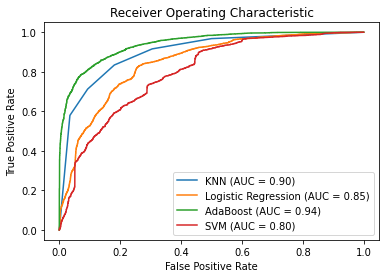

In [1458]:
# Define the number of folds for cross-validation
k = 5

## KNN ##
knn = KNeighborsClassifier(n_neighbors=best_params_knn['n_neighbors'])  # Set the desired value of k
knn.fit(X_train, y_train)

# Perform Cross Fold-K Validation and plot ROC curve for KNN
knn_scores = cross_val_score(knn, X_train, y_train, cv=k, scoring='roc_auc')
knn_mean_score = knn_scores.mean()

# Get predicted probabilities for positive class
knn_probs = knn.predict_proba(X_val)[:, 1]

# Compute false positive rate, true positive rate, and threshold for ROC curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC curve for KNN
plt.plot(fpr_knn, tpr_knn, label='KNN (AUC = %0.2f)' % roc_auc_knn)

## LOGISTIC REGRESSION ##
logistic_regression = LogisticRegression(solver='liblinear',C=best_params_lg['C'])  # Set the desired regularization parameter
logistic_regression.fit(X_train, y_train)

# Perform Cross Fold-K Validation and plot ROC curve for Logistic Regression
logreg_scores = cross_val_score(logistic_regression, X_train, y_train, cv=k, scoring='roc_auc')
logreg_mean_score = logreg_scores.mean()

# Get predicted probabilities for positive class
logreg_probs = logistic_regression.predict_proba(X_val)[:, 1]

# Compute false positive rate, true positive rate, and threshold for ROC curve
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_val, logreg_probs)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Plot ROC curve for Logistic Regression
plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression (AUC = %0.2f)' % roc_auc_logreg)

## ADA BOOST ##

# Perform Cross Fold-K Validation and plot ROC curve for AdaBoost
adaboost_scores = cross_val_score(adaboost, X_train, y_train, cv=k, scoring='roc_auc')
adaboost_mean_score = adaboost_scores.mean()

# Get predicted probabilities for positive class
adaboost_probs = adaboost.predict_proba(X_val)[:, 1]

# Compute false positive rate, true positive rate, and threshold for ROC curve
fpr_adaboost, tpr_adaboost, thresholds_adaboost = roc_curve(y_val, adaboost_probs)
roc_auc_adaboost = auc(fpr_adaboost, tpr_adaboost)

# Plot ROC curve for AdaBoost
plt.plot(fpr_adaboost, tpr_adaboost, label='AdaBoost (AUC = %0.2f)' % roc_auc_adaboost)


## SVM ##
svm = SVC(C=best_params_svm['C'],kernel='rbf')  # Set the desired kernel type and regularization parameter
svm.fit(X_train, y_train)

# Perform Cross Fold-K Validation and plot ROC curve for SVM
svm_scores = cross_val_score(svm, X_train, y_train, cv=k, scoring='roc_auc')
svm_mean_score = svm_scores.mean()

# Get predicted probabilities for positive class
svm_probs = svm.decision_function(X_val)

# Compute false positive rate, true positive rate, and threshold for ROC curve
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve for SVM
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = %0.2f)' % roc_auc_svm)

## RANDOM FOREST ##  - We did but then changed to AdaBoost, not part of the final work flow

# Perform Cross Fold-K Validation and plot ROC curve for Random Forest
#rf_scores = cross_val_score(random_forest, X_train, y_train, cv=k, scoring='roc_auc')
#rf_mean_score = rf_scores.mean()
# Get predicted probabilities for positive class
#rf_probs = random_forest.predict_proba(X_val)[:, 1]
# Compute false positive rate, true positive rate, and threshold for ROC curve
#fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, rf_probs)
#roc_auc_rf = auc(fpr_rf, tpr_rf)
# Plot ROC curve for Random Forest
#plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

# Set labels and title for the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Show the plot
plt.show()

At first we used Random Forest and then, after obtained better results on the test dataset using AdaBoost, we replace it because it suggests that the AdaBoost algorithm was able to generalize well and make accurate predictions on unseen data. This is a positive outcome and indicates that AdaBoost may be a suitable model choice for out project. 
Even though in the AUC validation for the random forest score we got 0.98 (higher than the 0.94 in the adaboost) but in the test AUC we got much better result with AdaBoost.

**The chosen Model : ADA BOOST** <br>
Among the models evaluated through k-fold cross-validation, AdaBoost achieved the highest AUC score of 0.94. This indicates that AdaBoost outperformed the other models and exhibited strong predictive capabilities for the given dataset.

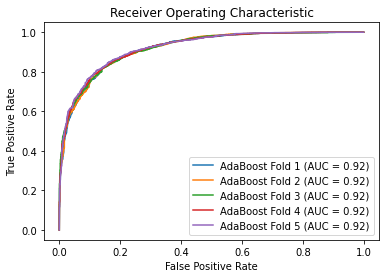

In [1459]:
#  A plot showing each fold for AdaBoost Model #
# Define the number of folds for cross-validation
k = 5

# Initialize lists to store fpr, tpr, and auc for each fold
fpr_list = []
tpr_list = []
auc_list = []

# Create an instance of AdaBoost classifier
adaboost = AdaBoostClassifier()

# Create an instance of KFold with the specified number of folds
kf = KFold(n_splits=k)

# Plot ROC curve for each fold of AdaBoost
for train_index, val_index in kf.split(X_train):
    train_fold_X, val_fold_X = X_train.iloc[train_index], X_train.iloc[val_index]
    train_fold_y, val_fold_y = y_train.iloc[train_index], y_train.iloc[val_index]

    # Fit the AdaBoost model on the train fold
    adaboost.fit(train_fold_X, train_fold_y)

    # Get predicted probabilities for the validation fold
    adaboost_probs = adaboost.predict_proba(val_fold_X)[:, 1]

    # Compute false positive rate, true positive rate, and threshold for ROC curve
    fpr, tpr, thresholds = roc_curve(val_fold_y, adaboost_probs)
    roc_auc = auc(fpr, tpr)

    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

    plt.plot(fpr, tpr, label='AdaBoost Fold %d (AUC = %0.2f)' % (len(auc_list), roc_auc))

# Set labels and title for the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Show the plot
plt.show()

**Validation Confusion Matrix for AdaBoost**

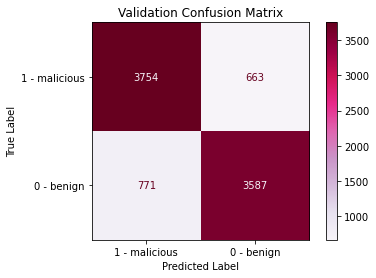

Validation Accuracy: 0.8365811965811966
Precision: 0.8296132596685083
Recall: 0.8498981208965362
F1 Score: 0.8396331916797137


In [1460]:
# Get the predicted labels for the validation set
adaboost_predictions = adaboost.predict(X_val)

# Compute the confusion matrix
cm = confusion_matrix(y_val, adaboost_predictions)
tn, fp, fn, tp = cm.ravel()

# Create a new confusion matrix with the desired order
cm_reordered = np.array([[tp, fn], [fp, tn]])

# Plot the confusion matrix
labels = ['1 - malicious', '0 - benign']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reordered, display_labels=labels)
disp.plot(cmap='PuRd')

# Set title and axis labels
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_val, adaboost_predictions)
print("Validation Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_val, adaboost_predictions)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_val, adaboost_predictions)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_val, adaboost_predictions)
print("F1 Score:", f1)

**An explanation of what each cell of the matrix represents in the context of AdaBoost model:** <br>
* True Positives (TP): This cell indicates the number of files (3754) that are truly malicious (class 1) and were correctly predicted as positive by AdaBoost model. These are the instances where the model made correct predictions of positive instances, correctly identifying them as malicious.

* False Positives (FP): This cell represents the number of files (771) that are actually benign (class 0) but were incorrectly predicted as positive by AdaBoost model. These are the instances where the model made an incorrect prediction by classifying benign files as malicious.

* False Negatives (FN): This cell indicates the number of files (663) that are truly positive (class 1) but were incorrectly predicted as negative by AdaBoost model. These are the instances where the model made an incorrect prediction by failing to classify malicious files as positive.

* True Negatives (TN): This cell represents the number of files (3587) that are actually negative (class 0) and were correctly predicted as negative by AdaBoost model. These are the instances where the model made correct predictions of negative instances, correctly identifying them as non-malicious.

Based on these observations, the following conclusions can be made about the model's performance in this context:
1. Accuracy: The accuracy of the model can be calculated by summing the number of true positives and true negatives and dividing it by the total number of instances. In this case, the accuracy would be 0.8365811965811966. It indicates the overall correctness of the model's predictions.

2. Precision: Precision is the proportion of true positive predictions out of all positive predictions (both true positives and false positives). It can be calculated as TP / (TP + FP). A higher precision value (0.8296132596685083) indicates a lower rate of falsely labeling benign files as malicious. It shows how well the model identifies truly malicious files among the predicted positive instances.

3. Recall (Sensitivity or True Positive Rate): Recall is the proportion of true positive predictions out of all actual positive instances (both true positives and false negatives). It can be calculated as TP / (TP + FN). A higher recall value (0.8498981208965362) indicates a lower rate of falsely labeling malicious files as benign. It demonstrates the model's ability to capture the majority of truly malicious files.

4. F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure of both precision and recall. It can be calculated as 2 * (Precision * Recall) / (Precision + Recall). A higher F1 score (0.8396331916797137) indicates a better balance between precision and recall, implying a better overall performance of the model in identifying both malicious and benign files accurately.

**Comparing the confusion matrices of the validation and train sets can provide insights into the performance gaps between running the AdaBoost model on these two datasets. It can also help determine if the model is overfitting and suggest potential steps to improve its generalization ability.**

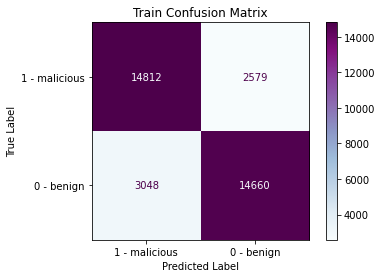

Validation Accuracy: 0.8396820422234251
Precision: 0.8293393057110863
Recall: 0.8517049048358346
F1 Score: 0.8403733227426172


In [1461]:
# Get the predicted labels for the training set
adaboost_predictions_train = adaboost.predict(X_train)

# Compute the confusion matrix
cm = confusion_matrix(y_train, adaboost_predictions_train)
tn, fp, fn, tp = cm.ravel()

# Create a new confusion matrix with the desired order
cm_reordered = np.array([[tp, fn], [fp, tn]])

# Plot the confusion matrix
labels = ['1 - malicious', '0 - benign']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reordered, display_labels=labels)
disp.plot(cmap='BuPu')

# Set title and axis labels
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_train, adaboost_predictions_train)
print("Validation Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_train, adaboost_predictions_train)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_train, adaboost_predictions_train)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_train, adaboost_predictions_train)
print("F1 Score:", f1)

**Performance Gaps:**

* Accuracy Gap: The accuracy on the train set (0.8397) is slightly higher than the validation set (0.8366), indicating a small performance gap between the two datasets. This suggests that the model may be slightly overfitting, but the difference is not significant.

* Precision Gap: The precision on the train set (0.8293) is slightly lower than the validation set (0.8296). The precision remains relatively consistent between the two sets.

* Recall Gap: The recall on the train set (0.8517) is slightly higher than the validation set (0.8499). The recall values also show a small difference, but it is not substantial.

* F1 Score Gap: The F1 score on the train set (0.8404) is slightly higher than the validation set (0.8396). This suggests that the model's ability to balance precision and recall is slightly better on the train set.

Overall, the performance gaps between the train and validation sets are relatively small. This indicates that the model is not significantly overfitting. However, there is still room for improvement to enhance its generalization ability.

**Initially, the model exhibited overfitting with a high validation accuracy of 0.84 and an exceptionally high training accuracy of 0.999. To reduce the gap between training and validation accuracies and mitigating overfitting and enhance the model's ability to generalize, several steps were taken:**

1. Feature Selection: instead of using PCA, which may not have been capturing the most informative features, backward selection was employed. Backward selection helps identify the most relevant features by iteratively removing the least important ones. By focusing on the most influential features, the model can potentially make better predictions and generalize more effectively.

2. Normilizeing categorial features: in the previous approach, one-hot encoding was used for the categorical features, which resulted in a significant increase in the number of columns, leading to a sparse dataset. To overcome this,a threshold was implemented to select only the most frequent unique values in the feature. encoding was adopted as an alternative. Late on, we decieded to switch from one-hot encoding with a threshold to target encoding. Our deciesion was driven by the aim to reduce dimensionality, mitigate the curse of dimensionality, and improve the model's generalization capability. Before changing to target encoding, the backward selection chose 29 features, and after it chose 24 features.

3. Feature Engineering: New features were created as detailed in the preprocessing part. The aim is to provide the model with more relevant and discriminative features.

4. Model Selection: The model was changed from Random Forest to AdaBoost. AdaBoost is an ensemble learning algorithm that combines multiple weak learners to create a strong classifier. It is known for its ability to handle complex relationships between features and the target variable. This change in model algorithm can potentially improve the model's generalization capabilities.

5. Regularization: Experiment with different regularization techniques, such as adjusting the learning rate or incorporating regularization parameters, to prevent overfitting and improve generalization.

6. Cross-Validation: by utilizing cross-validation techniques like k-fold cross-validation, we obtain a more comprehensive assessment of the model's generalization ability. It helps us gauge the model's performance across various subsets of the data, detect overfitting, and optimize hyperparameters.

In order to evaluate the generalization performance of our model, we utilized a separate test dataset that was initially split from the training data. We applied our trained model to this test dataset and calculated the Area Under the Curve (AUC) score :

In [1462]:
# Get predicted probabilities for positive class
adaboost_probs = adaboost.predict_proba(X_test.loc[:, features_bk])[:, 1]

# Compute false positive rate, true positive rate, and threshold for ROC curve
fpr_adaboost, tpr_adaboost, thresholds_adaboost = roc_curve(y_test, adaboost_probs)

# Calculate AUC score
roc_auc_adaboost = auc(fpr_adaboost, tpr_adaboost)

# Print the AUC score
print("AUC Score (AdaBoost):", roc_auc_adaboost)

AUC Score (AdaBoost): 0.8091444043747495


In [1463]:
end_time = time.time()
total_time = end_time - start_time
print("Total Time:",total_time,"Seconds")

Total Time: 2537.3529074192047 Seconds


# PART 5 - PREDICATION 

We developed a preprocessing function that encapsulates all the actions we performed in the preprocessing part. Later, we used it as part of the pipline function we created as well. 

In [1464]:
def preprocess_data(X_train, y_train, X_test):
    # Count the number of unique values in each column
    unique_counts = X_train.nunique()
    # Identify binary features (features with 2 unique values)
    binary_features = unique_counts[unique_counts == 2].index
    # Convert binary features to categorical data type
    X_train[binary_features] = X_train[binary_features].astype('category')
    # Separate numeric and categorical features
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns  # includes the label
    # Remove outliers using z-score for the 'A' feature
    X_train, y_train = remove_outliers_zscore(X_train, y_train, 'A')
    # Fill missing values for numeric features
    X_train, X_test = fill_missing_values_numeric(X_train, X_test, numeric_features)
    # Fill missing values for categorical features
    X_train, X_test = fill_missing_values_categorical(X_train, X_test, categorical_features)
    # Apply log transformation to 'size', 'vsize', and 'printables' features
    X_train, X_test = apply_log_transformation(X_train, X_test, ['size', 'vsize', 'printables'])
    # Remove outliers using LOF for selected numeric features
    X_train, y_train = remove_outliers_lof(X_train, y_train, ['size', 'imports', 'exports', 'symbols', 'urls', 'MZ', 'printables'])
    # Drop 'sha256' and 'numstrings' features from training data
    X_train = drop_features(X_train, ['sha256', 'numstrings'])
    # Drop 'sha256' and 'numstrings' features from test data
    X_test = drop_features(X_test, ['sha256', 'numstrings'])
    numeric_features = numeric_features.difference(['numstrings'])
    categorical_features = categorical_features.difference(['sha256'])
    # Create additional features
    X_train, X_test = create_additional_features(X_train, X_test)
    # Normalize numeric features (excluding 'B') using MinMaxScaler
    X_train, X_test = normalize_features(X_train, X_test, numeric_features, ['B'])
    # Apply Box-Cox transformation to the 'B' feature
    X_train, X_test = apply_boxcox_transformation(X_train, X_test, 'B')
    # Target encode categorical columns: "file_type_trid" and "C"
    columns_to_encode = ["file_type_trid", "C"]
    X_train, X_test = target_encode_columns(X_train, X_test, y_train, columns_to_encode)
    return X_train, y_train, X_test


**Pipeline Function :**

In [1465]:
def pipline(train_path,test_path,results_path):

    train_data = pd.read_csv(train_path)
    X_train = train_data.iloc[:, :-1]  # Select all columns except the last one as features
    y_train = train_data.iloc[:, -1]  # Select the last column as labels
    X_test = pd.read_csv(test_path)
    sha256_val = X_test['sha256']
    X_train, y_train, X_test = preprocess_data(X_train, y_train, X_test)

    # Grid search
    # Define the hyperparameter grid
    param_grid = {'n_estimators': [150,200,250], 'learning_rate': [1.0,1.5, 1.8]}
    # Create the AdaBoost classifier
    adaboost = AdaBoostClassifier()
    # Perform grid search cross-validation
    grid_search = GridSearchCV(adaboost, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    # Get the best hyperparameters
    best_params_adaboost = grid_search.best_params_
    # AdaBoosting model training
    model = AdaBoostClassifier(n_estimators=best_params_adaboost['n_estimators'], learning_rate=best_params_adaboost['learning_rate'])
    model.fit(X_train, y_train)

    # Prediction
    predictions = model.predict_proba(X_test)
    results = pd.DataFrame({'sha256': sha256_val, 'predict_proba': predictions[:, 1]})
    results.to_csv(results_path, index=False)

In [1466]:
pipline('train.csv','test.csv','results_12.csv')

Number of ouliers in feature A : 379
Number of ouliers in feature size : 4770
